The traffic.csv file contains the following columns:

DateTime: Timestamp of traffic data collection.
Junction: ID of the junction where data is collected.
Vehicles: Count of vehicles observed during the specific time interval.
ID: Unique identifier for each record.


1. Import Necessary Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


2. Load and Prepare the Data

In [19]:
# Load the dataset
data = pd.read_csv('traffic.csv')

# Convert DateTime to a proper datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Extract useful features from DateTime
data['Hour'] = data['DateTime'].dt.hour
data['Day'] = data['DateTime'].dt.day
data['Month'] = data['DateTime'].dt.month
data['Weekday'] = data['DateTime'].dt.weekday

# Drop unnecessary columns
data.drop(columns=['DateTime', 'ID'], inplace=True)

# Check for missing values
print(data.isnull().sum())


Junction    0
Vehicles    0
Hour        0
Day         0
Month       0
Weekday     0
dtype: int64


3. Exploratory Data Analysis</br>
Plot traffic patterns

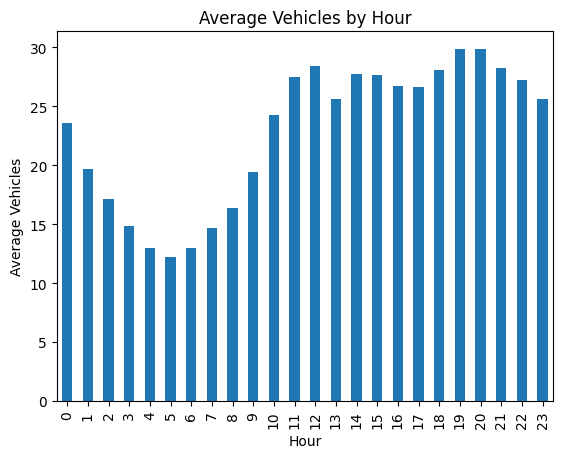

In [20]:
# Traffic density by hour
hourly_traffic = data.groupby('Hour')['Vehicles'].mean()
hourly_traffic.plot(kind='bar', title='Average Vehicles by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Vehicles')
plt.show()


Identify high-traffic junctions



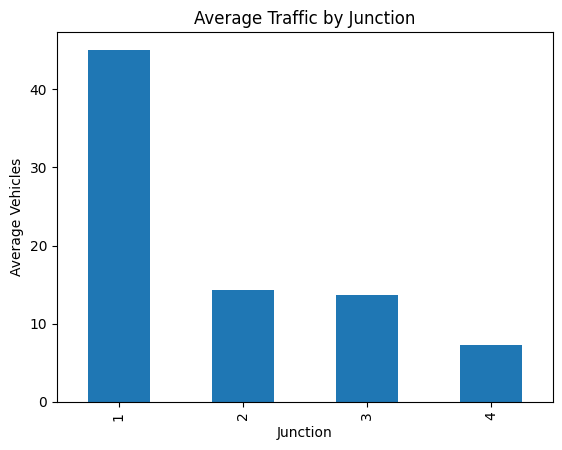

In [21]:
junction_traffic = data.groupby('Junction')['Vehicles'].mean()
junction_traffic.sort_values(ascending=False).plot(kind='bar', title='Average Traffic by Junction')
plt.xlabel('Junction')
plt.ylabel('Average Vehicles')
plt.show()


4. Apply Clustering (K-Means) for Traffic Congestion


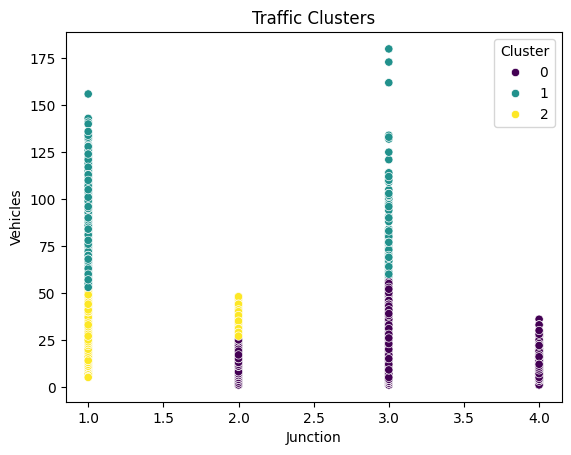

In [22]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = data[['Junction', 'Vehicles']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Use 3 clusters: Low, Medium, High congestion
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
sns.scatterplot(x='Junction', y='Vehicles', hue='Cluster', data=data, palette='viridis')
plt.title('Traffic Clusters')
plt.show()


5. Predict Future Traffic Patterns


In [23]:
# Define features and target
X = data[['Junction', 'Hour', 'Day', 'Month', 'Weekday']]
y = data['Vehicles']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))


R2 Score: 0.8684140547753278
Mean Squared Error: 53.62742352452203


6. Recommend Traffic Light Installation


In [24]:
# Predict traffic for all data
data['Predicted_Vehicles'] = rf.predict(X)

# Identify high-congestion junctions
high_traffic_junctions = data[data['Predicted_Vehicles'] > data['Predicted_Vehicles'].quantile(0.75)]
high_traffic_junctions = high_traffic_junctions.groupby('Junction')['Predicted_Vehicles'].mean().sort_values(ascending=False)

print("Recommended Junctions for Traffic Lights:")
print(high_traffic_junctions)


Recommended Junctions for Traffic Lights:
Junction
1    53.025990
3    41.734115
2    33.887216
Name: Predicted_Vehicles, dtype: float64


7. Visualization of Recommendations



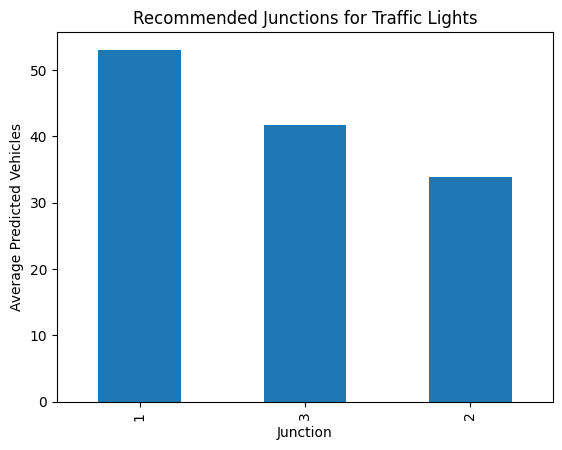

In [25]:
# Plot high-congestion junctions
high_traffic_junctions.plot(kind='bar', title='Recommended Junctions for Traffic Lights')
plt.xlabel('Junction')
plt.ylabel('Average Predicted Vehicles')
plt.show()


8. Optimization Using Clusters


In [26]:
# Assign weights to clusters
data['Cluster_Score'] = data['Cluster'].map({0: 0, 1: 1, 2: 2})  # Adjust cluster mapping based on results
data['Priority_Score'] = data['Predicted_Vehicles'] * data['Cluster_Score']

# Identify junctions with the highest priority
priority_junctions = data.groupby('Junction')['Priority_Score'].mean().sort_values(ascending=False)

print("Top Priority Junctions for Traffic Light Installation:")
print(priority_junctions.head(10))


Top Priority Junctions for Traffic Light Installation:
Junction
1    67.907556
2     5.202754
3     0.474966
4     0.000000
Name: Priority_Score, dtype: float64
